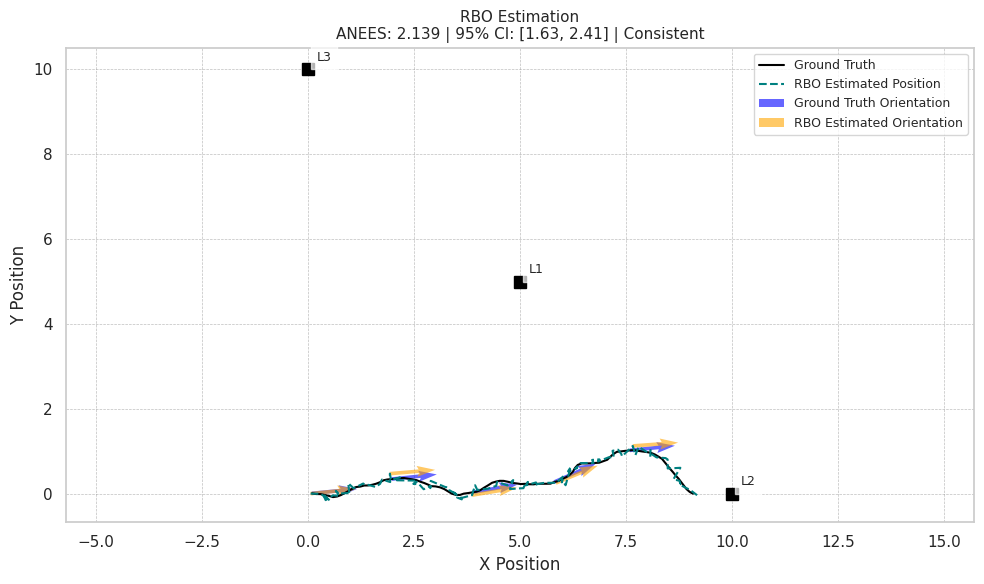

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2

df_gt = pd.read_csv("ekf_simulation_data.csv")
num_steps = len(df_gt)
ground_truth_positions = df_gt[['x_actual', 'y_actual']].values
ground_truth_orientations = df_gt['theta_actual'].values

# Configuration (same as EKF_v2 for consistency)
landmarks = np.array([[5, 5], [10, 0], [0, 10]])
camera_errors = [(0.1, 0.05), (0.1, 0.05), (0.1, 0.05)]  # Same as Drho, Dphi
robot_phi_error = 0.05  # Dphi

est_positions = []
est_orientations = []
est_covariances = []

rng_sensor = np.random.default_rng(123)

for step in range(num_steps):
    x, y = ground_truth_positions[step]
    theta = ground_truth_orientations[step]

    sensor_positions = []
    sensor_covariances = []
    for i, (lx, ly) in enumerate(landmarks):
        dx = x - lx
        dy = y - ly
        r = np.sqrt(dx**2 + dy**2)
        angle = np.arctan2(dy, dx)

        dr, dtheta = camera_errors[i]
        r_meas = r + rng_sensor.normal(0, dr)
        theta_meas = angle + rng_sensor.normal(0, dtheta)

        est_x = lx + r_meas * np.cos(theta_meas)
        est_y = ly + r_meas * np.sin(theta_meas)
        sensor_positions.append((est_x, est_y))

        J = np.array([
            [np.cos(theta_meas), -r_meas * np.sin(theta_meas)],
            [np.sin(theta_meas),  r_meas * np.cos(theta_meas)]
        ])
        cov = J @ np.diag([dr**2, dtheta**2]) @ J.T
        sensor_covariances.append(cov)

    Sigma_inv_sum = np.zeros((2, 2))
    weighted_sum = np.zeros(2)
    for i in range(3):
        cov_inv = np.linalg.inv(sensor_covariances[i])
        Sigma_inv_sum += cov_inv
        weighted_sum += cov_inv @ np.array(sensor_positions[i])

    Sigma_pos = np.linalg.inv(Sigma_inv_sum)
    est_pos = Sigma_pos @ weighted_sum
    est_positions.append(est_pos)
    est_covariances.append(Sigma_pos)

    orientation_estimates = []
    weights = []
    for i, (lx, ly) in enumerate(landmarks):
        dx = lx - est_pos[0]
        dy = ly - est_pos[1]
        theta_global = np.arctan2(dy, dx)

        dx_true = lx - x
        dy_true = ly - y
        phi = np.arctan2(dy_true, dx_true) - theta
        phi += rng_sensor.normal(0, robot_phi_error)

        psi_i = theta_global - phi
        psi_i = np.arctan2(np.sin(psi_i), np.cos(psi_i))

        d_sq = dx**2 + dy**2
        var_theta_global = ((dx**2 * Sigma_pos[1,1] + dy**2 * Sigma_pos[0,0] -
                            2 * dx * dy * Sigma_pos[0,1]) / d_sq**2)
        var_psi_i = var_theta_global + robot_phi_error**2
        weight = 1 / var_psi_i

        orientation_estimates.append(psi_i)
        weights.append(weight)

    weights = np.array(weights)
    orientation_estimates = np.array(orientation_estimates)
    sin_sum = np.sum(weights * np.sin(orientation_estimates))
    cos_sum = np.sum(weights * np.cos(orientation_estimates))
    psi_est = np.arctan2(sin_sum, cos_sum)
    est_orientations.append(psi_est)

true_positions = ground_truth_positions
true_orientations = np.unwrap(ground_truth_orientations)
est_positions = np.array(est_positions)
est_orientations = np.unwrap(np.array(est_orientations))

cov_xx = [cov[0, 0] for cov in est_covariances]
cov_xy = [cov[0, 1] for cov in est_covariances]
cov_yx = [cov[1, 0] for cov in est_covariances]
cov_yy = [cov[1, 1] for cov in est_covariances]

df_rbo = pd.DataFrame({
    'x_actual': true_positions[:, 0],
    'y_actual': true_positions[:, 1],
    'theta_actual': true_orientations,
    'x_estimated': est_positions[:, 0],
    'y_estimated': est_positions[:, 1],
    'theta_estimated': est_orientations,
    'covXX': cov_xx,
    'covXY': cov_xy,
    'covYX': cov_yx,
    'covYY': cov_yy
})
df_rbo.to_csv("rbo_simulation_data.csv", index=False)

# ANEES
errors = df_rbo[['x_actual', 'y_actual']].values - df_rbo[['x_estimated', 'y_estimated']].values
covs = [np.array([[row.covXX, row.covXY], [row.covYX, row.covYY]]) for _, row in df_rbo.iterrows()]
N = len(df_rbo)
d = 2
alpha = 0.05
anees = np.mean([
    e.reshape(1, -1) @ np.linalg.inv(P) @ e.reshape(-1, 1)
    if np.linalg.cond(P) < 1e12 else np.nan
    for P, e in zip(covs, errors)
])
dof = N * d
chi2_bounds = (chi2.ppf(alpha / 2, dof) / N, chi2.ppf(1 - alpha / 2, dof) / N)
consistency = "Consistent" if chi2_bounds[0] <= anees <= chi2_bounds[1] else "Inconsistent"

import seaborn as sns

# Apply cleaner plotting style
sns.set_context("notebook")
sns.set_style("whitegrid")

# Create improved static plot
plt.figure(figsize=(10, 6))
plt.plot(df_rbo.x_actual, df_rbo.y_actual, 'k-', label='Ground Truth')
plt.plot(df_rbo.x_estimated, df_rbo.y_estimated, 'teal', linestyle='--', label='RBO Estimated Position')

# Sparser and more transparent arrows
skip = 20
plt.quiver(df_rbo.x_actual[::skip], df_rbo.y_actual[::skip],
           np.cos(df_rbo.theta_actual[::skip]), np.sin(df_rbo.theta_actual[::skip]),
           color='blue', scale=20, width=0.004, alpha=0.6, label='Ground Truth Orientation')
plt.quiver(df_rbo.x_estimated[::skip], df_rbo.y_estimated[::skip],
           np.cos(df_rbo.theta_estimated[::skip]), np.sin(df_rbo.theta_estimated[::skip]),
           color='orange', scale=20, width=0.004, alpha=0.6, label='RBO Estimated Orientation')

# Plot and label landmarks
for i, (lx, ly) in enumerate(landmarks):
    plt.plot(lx, ly, 'ks', markersize=8)
    plt.text(lx + 0.2, ly + 0.2, f"L{i+1}", fontsize=9, bbox=dict(facecolor='white', alpha=0.7))

# Enhanced title and labels
plt.title(
    f"RBO Estimation\n"
    f"ANEES: {anees:.3f} | 95% CI: [{chi2_bounds[0]:.2f}, {chi2_bounds[1]:.2f}] | {consistency}",
    fontsize=11
)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.axis('equal')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.savefig("rbo_path_arrows_landmark")




